# Data Science Career Data Exploratory Analysis

Author: Cole Wagner

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, Lasso, ElasticNet
from sklearn.model_selection import KFold, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Data Preprocessing

In [6]:
# read in data
DS_salary = pd.read_csv('data_cleaned_2021.csv')
DS_salary.head()

,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,tensor,hadoop,tableau,bi,flink,mongo,google_an,job_title_sim,seniority_by_title,Degree
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 - 1000,1973,...,0,0,1,1,0,0,0,data scientist,na,M
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+,1984,...,0,0,0,0,0,0,0,data scientist,na,M
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 - 1000,2010,...,0,0,0,0,0,0,0,data scientist,na,M
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 - 5000,1965,...,0,0,0,0,0,0,0,data scientist,na,na
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 - 200,1998,...,0,0,0,0,0,0,0,data scientist,na,na


In [119]:
# extract only variables that are relevant to this analysis
relevant_variables = ['Rating', 'Size', 'Founded',
                      'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Hourly', 
                      'Employer provided', 'Lower Salary', 'Upper Salary', 'Avg Salary(K)', 
                      'Job Location', 'Age', 'Python', 'spark', 'aws', 'excel', 'sql', 'sas', 
                      'keras', 'pytorch', 'scikit', 'tensor', 'hadoop', 'tableau', 'bi', 'flink',
                      'mongo', 'google_an', 'job_title_sim', 'seniority_by_title', 'Degree']

initial_DS = DS_salary[relevant_variables]
initial_DS.shape

(742, 33)

My first preprocessing step is to look over the variables and see which ones could potentially be used in this data analysis. In doing this, I removed the following variables (with reasoning provided):

* Salary Estimate: This variable has far too many factor levels to be of use for this data analysis. Especially considering there are other numeric variables that describe the salary of each position.
* Job Title: There is a simplified version of this variable that will be more useful for data analysis.
* Company Name: There are other variables that will describe features of a company than its name, which is too unique to have much value in this EDA.
* Job Description: This column has values that are far too long and too unique to be of much use in a data analysis. In addition, this variable is better summarized by all of the binary skill variables.
* Location: There is a simplified version of this variable containing only the state, which is more useful for data analysis.
* Headquarters: This variable has too many unique locations to have much use in EDA, especially considering the simplified location variable.
* Competitors: This variable is at least 61% empty, making it very difficult to analyze with any statistical significance.
* company_txt: Once again, there are so many different companies that this variable is better summarized in the industry and sector variables for the purposes of this analysis.

This is only upon a preliminary examination of the data, and more variables may be removed/modified.

In [120]:
# check for NaN values
initial_DS.isna().sum().to_frame()
# there are none, so we know that any missing values will be represented by -1

,0
Rating,0
Size,0
Founded,0
Type of ownership,0
Industry,0
Sector,0
Revenue,0
Hourly,0
Employer provided,0
Lower Salary,0


In [121]:
# see which variables have -1 values
# see: https://stackoverflow.com/questions/58718295/count-the-number-of-values-that-satisfy-a-condition-in-every-column-of-a-pandas
(initial_DS == -1).sum().to_frame()


,0
Rating,11
Size,0
Founded,50
Type of ownership,0
Industry,0
Sector,0
Revenue,0
Hourly,0
Employer provided,0
Lower Salary,0


Considering there are relatively few missing values in Rating, Age, and Founded (and none in the rest), I will impute each missing numeric value with the median value from that column.

In [122]:
# see: https://www.geeksforgeeks.org/how-to-replace-values-in-column-based-on-condition-in-pandas/
initial_DS.loc[initial_DS["Rating"] == -1, "Rating"] = initial_DS["Rating"].median()
initial_DS.loc[initial_DS["Founded"] == -1, "Founded"] = initial_DS["Founded"].median()
initial_DS.loc[initial_DS["Age"] == -1, "Age"] = initial_DS["Age"].median()

In [123]:
# ensure all numeric missing values have been dealt with
(initial_DS == -1).sum().to_frame()

,0
Rating,0
Size,0
Founded,0
Type of ownership,0
Industry,0
Sector,0
Revenue,0
Hourly,0
Employer provided,0
Lower Salary,0


In [124]:
initial_DS.head()

,Rating,Size,Founded,Type of ownership,Industry,Sector,Revenue,Hourly,Employer provided,Lower Salary,...,tensor,hadoop,tableau,bi,flink,mongo,google_an,job_title_sim,seniority_by_title,Degree
0,3.8,501 - 1000,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),0,0,53,...,0,0,1,1,0,0,0,data scientist,na,M
1,3.4,10000+,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),0,0,63,...,0,0,0,0,0,0,0,data scientist,na,M
2,4.8,501 - 1000,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),0,0,80,...,0,0,0,0,0,0,0,data scientist,na,M
3,3.8,1001 - 5000,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),0,0,56,...,0,0,0,0,0,0,0,data scientist,na,na
4,2.9,51 - 200,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,0,0,86,...,0,0,0,0,0,0,0,data scientist,na,na


In [125]:
# See variable types for each column
initial_DS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rating              742 non-null    float64
 1   Size                742 non-null    object 
 2   Founded             742 non-null    int64  
 3   Type of ownership   742 non-null    object 
 4   Industry            742 non-null    object 
 5   Sector              742 non-null    object 
 6   Revenue             742 non-null    object 
 7   Hourly              742 non-null    int64  
 8   Employer provided   742 non-null    int64  
 9   Lower Salary        742 non-null    int64  
 10  Upper Salary        742 non-null    int64  
 11  Avg Salary(K)       742 non-null    float64
 12  Job Location        742 non-null    object 
 13  Age                 742 non-null    int64  
 14  Python              742 non-null    int64  
 15  spark               742 non-null    int64  
 16  aws     

In [126]:
# see unique values of each variable to determine if there are any other missing values formatted differently.
for i in range(len(initial_DS.columns)):
    print(initial_DS.columns[i])
    print(initial_DS.iloc[:, i].unique())

Rating
[3.8 3.4 4.8 2.9 4.1 3.3 4.6 3.5 3.2 3.7 3.6 3.9 4.3 4.2 4.  4.7 5.  3.1
 4.4 2.8 2.7 1.9 4.5 3.  2.3 2.6 2.4 2.5 2.2 2.1]
Size
['501 - 1000 ' '10000+ ' '1001 - 5000 ' '51 - 200 ' '201 - 500 '
 '5001 - 10000 ' '1 - 50 ' 'unknown']
Founded
[1973 1984 2010 1965 1998 2000 2008 2005 2014 2009 2011 1968 1962 2012
 1781 1995 1915 2013 1935 1849 1952 1852 1997 1996 1974 1969 1870 1985
 1988 2015 1993 1958 1986 1999 1925 1912 2002 1863 1939 2016 1885 2006
 1948 2003 1927 1978 1860 2017 1942 1990 2001 2007 1992 1994 1977 2019
 1982 1937 1878 1966 1971 1943 1987 1945 1846 1851 1976 1981 1970 1951
 1967 1961 1964 1930 1917 1883 1887 2004 1850 1902 1744 1929 1947 1991
 1989 1928 1875 1913 1972 1856 1983 1922 1812 1914 1980 1954 1830 1975
 1899 1979 1889]
Type of ownership
['Company - Private' 'Other Organization' 'Government' 'Company - Public'
 'Hospital' 'Subsidiary or Business Segment' 'Nonprofit Organization'
 'College / University' 'School / School District']
Industry
['Aerospace & Def

Here, we see that many categorical variables have missing values under different factors. Therefore, we must deal with each column individually.

### Size

In [127]:
initial_DS['Size'].value_counts()

Size
1001 - 5000      150
501 - 1000       134
10000+           130
201 - 500        117
51 - 200          94
5001 - 10000      76
1 - 50            31
unknown           10
Name: count, dtype: int64

Seeing that there are relatively few missing values here, it is reasonable to impute all 'unknown' values with the mode.

In [128]:
initial_DS.loc[initial_DS["Size"] == "unknown", "Size"] = "1001 - 5000"

### Industry

In [129]:
initial_DS['Industry'].value_counts()

Industry
Biotech & Pharmaceuticals                   112
Insurance Carriers                           63
Computer Hardware & Software                 59
IT Services                                  50
Health Care Services & Hospitals             49
Enterprise Software & Network Solutions      42
Internet                                     29
Consulting                                   29
Aerospace & Defense                          25
Advertising & Marketing                      25
Consumer Products Manufacturing              20
Research & Development                       19
Colleges & Universities                      16
Energy                                       14
Banks & Credit Unions                        12
Federal Agencies                             11
-1                                           10
Staffing & Outsourcing                       10
Travel Agencies                               8
Lending                                       8
Food & Beverage Manufacturing  

Upon examining a frequency table for this variable, there are many factor levels with < 10 observations. Especially considering the presence of a sector variable, industry may not provide much additional insight and does not appear to be a variable worth keeping in the dataset for these reasons.

In [130]:
initial_DS = initial_DS.drop('Industry', axis=1)

### Sector

In [131]:
initial_DS['Sector'].value_counts()

Sector
Information Technology                180
Biotech & Pharmaceuticals             112
Business Services                      97
Insurance                              69
Health Care                            49
Finance                                42
Manufacturing                          34
Aerospace & Defense                    25
Education                              23
Retail                                 15
Oil, Gas, Energy & Utilities           14
Government                             11
-1                                     10
Non-Profit                              9
Transportation & Logistics              8
Real Estate                             8
Travel & Tourism                        8
Telecommunications                      6
Media                                   6
Arts, Entertainment & Recreation        4
Consumer Services                       4
Mining & Metals                         3
Construction, Repair & Maintenance      3
Agriculture & Forestry     

It is reasonable to impute all '-1' values here, considering there are relatively few missing values.

In [132]:
initial_DS.loc[initial_DS["Sector"] == "-1", "Sector"] = "Information Technology"


### Revenue

In [133]:
initial_DS['Revenue'].value_counts()

Revenue
Unknown / Non-Applicable            204
$10+ billion (USD)                  124
$100 to $500 million (USD)           91
$1 to $2 billion (USD)               60
$500 million to $1 billion (USD)     57
$50 to $100 million (USD)            46
$25 to $50 million (USD)             40
$2 to $5 billion (USD)               39
$10 to $25 million (USD)             32
$5 to $10 billion (USD)              19
$5 to $10 million (USD)              18
$1 to $5 million (USD)                8
Less than $1 million (USD)            4
Name: count, dtype: int64

In this case, 'Unknown / Non-Applicable' is the largest factor level, and thus it should not be imputed to any of the other factor levels. In addition, all observations with this factor level shouldn't be removed, as that would cause us to lose a large chunk of our data. It seems most reasonable to leave this variable as-is. Non-Applicable could also include companies who have no revenue at this point. Overall, while this variable may eventually need to be removed from the dataset, it deserves further analysis.

### job_title_sim

In [134]:
initial_DS['job_title_sim'].value_counts()

job_title_sim
data scientist                    313
other scientist                   143
data engineer                     119
analyst                           101
machine learning engineer          22
Data scientist project manager     16
na                                 10
data analitics                      8
data modeler                        5
director                            5
Name: count, dtype: int64

With relatively few missing values (especially in proportion to the number of factor levels), it is reasonable to impute all missing values with the mode.

In [135]:
initial_DS.loc[initial_DS["job_title_sim"] == "na", "job_title_sim"] = "data scientist"


### seniority_by_title

In [136]:
initial_DS['seniority_by_title'].value_counts()

seniority_by_title
na    519
sr    220
jr      3
Name: count, dtype: int64

Seeing as a majority of observations in this variable are 'na', it is reasonable to remove this variable from the dataset.

In [137]:
initial_DS = initial_DS.drop('seniority_by_title', axis=1)

### Degree

In [138]:
initial_DS['Degree'].value_counts()

Degree
na    383
M     252
P     107
Name: count, dtype: int64

Once again, the most common factor level in this variable is 'na'. As a result, it is reasonable to remove this variable from our dataset.

In [139]:
nomissing_DS = initial_DS.drop('Degree', axis=1)
nomissing_DS.shape

(742, 30)

After processing missing values, our dataset has 30 variables and 742 observations.

## Data Summary

In [140]:
nomissing_DS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rating             742 non-null    float64
 1   Size               742 non-null    object 
 2   Founded            742 non-null    int64  
 3   Type of ownership  742 non-null    object 
 4   Sector             742 non-null    object 
 5   Revenue            742 non-null    object 
 6   Hourly             742 non-null    int64  
 7   Employer provided  742 non-null    int64  
 8   Lower Salary       742 non-null    int64  
 9   Upper Salary       742 non-null    int64  
 10  Avg Salary(K)      742 non-null    float64
 11  Job Location       742 non-null    object 
 12  Age                742 non-null    int64  
 13  Python             742 non-null    int64  
 14  spark              742 non-null    int64  
 15  aws                742 non-null    int64  
 16  excel              742 non

Among the variables left, 6 are categorical and 24 are numeric.

### Numeric, Nonbinary Variables

In [141]:
# create a dataset with all numeric, nonbinary variables
nonbinary_variables = ['Rating', 'Founded', 'Lower Salary', 'Upper Salary',
                      'Avg Salary(K)', 'Age']
nonbin_DS = nomissing_DS[nonbinary_variables]
nonbin_DS.describe()

,Rating,Founded,Lower Salary,Upper Salary,Avg Salary(K),Age
count,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,3.688544,1971.184636,74.754717,128.214286,101.484501,49.276280
std,0.566106,52.428471,30.945892,45.128650,37.482449,52.639588
min,1.900000,1744.000000,15.000000,16.000000,15.500000,2.000000
25%,3.300000,1961.000000,52.000000,96.000000,73.500000,14.000000
50%,3.700000,1988.000000,69.500000,124.000000,97.500000,25.000000
75%,4.000000,2007.000000,91.000000,155.000000,122.500000,60.000000
max,5.000000,2019.000000,202.000000,306.000000,254.000000,277.000000


From these summary statistics, we can conclude the following:
* Rating is left skewed, with over 75% of companies achieving a rating of 3 or above
* 75% of companies were founded after 1960, but there are a few companies that are much older. The oldest was founded in 1744!
* Lower, Upper, and Average salaries are all slightly right skewed. There seem to be a small subset of jobs that have much higher salary ranges than the rest.
* Age shows the inverse of the trend displayed in Founded.

### Binary Variables

In [142]:
# create a dataset with all binary variables
binary_variables = ['Hourly', 'Employer provided', 'Python', 'spark',
                   'aws', 'excel', 'sql', 'sas', 'keras', 'pytorch', 
                    'scikit', 'tensor', 'hadoop', 'tableau', 'bi', 
                    'flink', 'mongo', 'google_an']

bin_DS = nomissing_DS[binary_variables]

for i in range(len(bin_DS.columns)):
    print(" ")
    print(bin_DS.iloc[:, i].value_counts())

 
Hourly
0    718
1     24
Name: count, dtype: int64
 
Employer provided
0    725
1     17
Name: count, dtype: int64
 
Python
1    392
0    350
Name: count, dtype: int64
 
spark
0    575
1    167
Name: count, dtype: int64
 
aws
0    566
1    176
Name: count, dtype: int64
 
excel
1    388
0    354
Name: count, dtype: int64
 
sql
1    380
0    362
Name: count, dtype: int64
 
sas
0    676
1     66
Name: count, dtype: int64
 
keras
0    713
1     29
Name: count, dtype: int64
 
pytorch
0    703
1     39
Name: count, dtype: int64
 
scikit
0    688
1     54
Name: count, dtype: int64
 
tensor
0    670
1     72
Name: count, dtype: int64
 
hadoop
0    618
1    124
Name: count, dtype: int64
 
tableau
0    594
1    148
Name: count, dtype: int64
 
bi
0    686
1     56
Name: count, dtype: int64
 
flink
0    732
1     10
Name: count, dtype: int64
 
mongo
0    705
1     37
Name: count, dtype: int64
 
google_an
0    728
1     14
Name: count, dtype: int64


These frequency tables provide the following information:
* Python is the most commonly required skill, followed closely by Excel and SQL.
* The least commonly required skill is Flink, followed by Google Analytics and Keras.
* A vast majority of jobs do not have an hourly rate, implying that they are salaried positions.
* Very few employers provided their salaries on Glassdoor.

### Categorical Variables

In [143]:
# create a dataset with all categorical variables
categorical_variables = ['Size', 'Type of ownership', 'Sector', 
                         'Revenue', 'Job Location', 'job_title_sim']

cat_DS = nomissing_DS[categorical_variables]

for i in range(len(cat_DS.columns)):
    print(" ")
    print(cat_DS.iloc[:, i].value_counts())

 
Size
1001 - 5000      150
501 - 1000       134
10000+           130
201 - 500        117
51 - 200          94
5001 - 10000      76
1 - 50            31
1001 - 5000       10
Name: count, dtype: int64
 
Type of ownership
Company - Private                 410
Company - Public                  193
Nonprofit Organization             55
Subsidiary or Business Segment     34
Government                         15
Hospital                           15
College / University               13
Other Organization                  5
School / School District            2
Name: count, dtype: int64
 
Sector
Information Technology                190
Biotech & Pharmaceuticals             112
Business Services                      97
Insurance                              69
Health Care                            49
Finance                                42
Manufacturing                          34
Aerospace & Defense                    25
Education                              23
Retail                  

From these frequency tables, we see:

* A majority of companies employing data scientists are quite large (over 500 employees).
* Most of these companies are private corporations in the IT industry.
* Most companies do not report their revenue on Glassdoor (which could be an issue with the dataset).
* The top three states employing the most data scientists are California, Massachusetts, and New York.
* The most common job title for these positions is "Data Scientist".

## Data Visualization

### Distribution of Average Salary

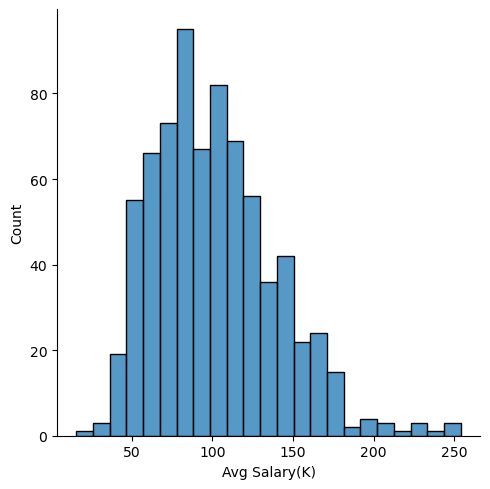

In [144]:
# create a histogram for avg salary
sns.displot(nomissing_DS, x="Avg Salary(K)")

As seen in the summary statistics, average salary is right skewed, with only a few positions earning over 200k per year on average. A majority of average salaries lie between 50k and 150k.

### Relationship Between Average Salary and Rating

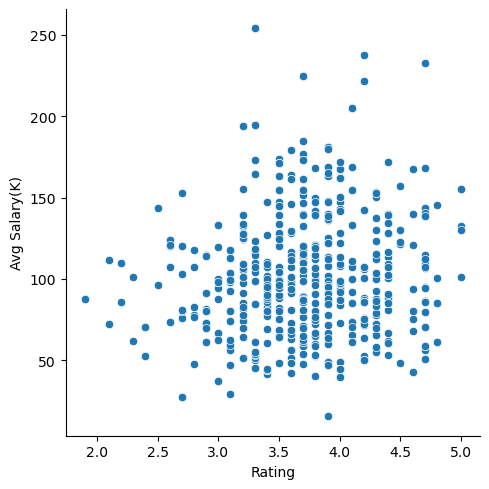

In [145]:
sns.relplot(x='Rating', y='Avg Salary(K)', data=nomissing_DS)

There does not seem to be a general trend between a company's rating and their position's average salary.

### Relationship Between Company Age and Average Salary

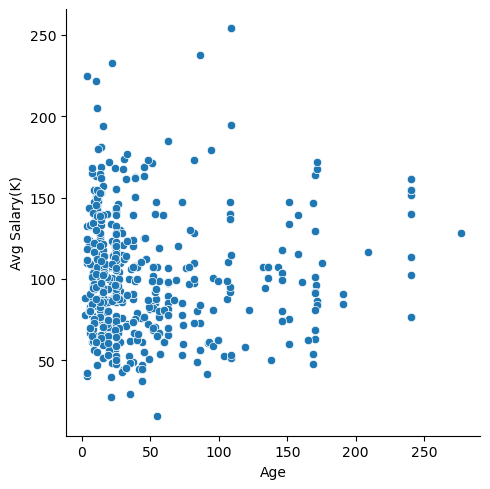

In [146]:
sns.relplot(x='Age', y='Avg Salary(K)', data=nomissing_DS)

It appears that there is potential for a trend here, which may be more clear with log transformations

In [147]:
# log transform avg salary

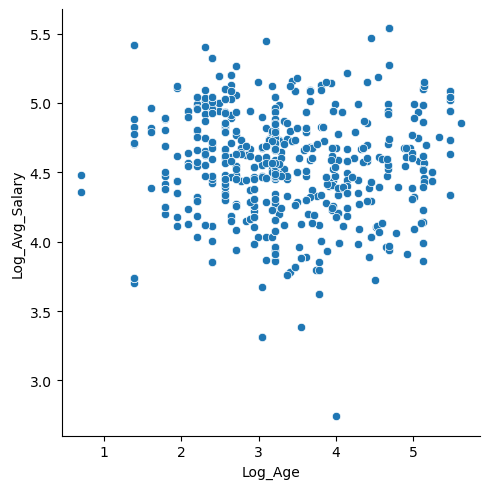

In [148]:
nomissing_DS['Log_Avg_Salary'] = np.log(nomissing_DS['Avg Salary(K)'])
nomissing_DS['Log_Age'] = np.log(nomissing_DS['Age'])
sns.relplot(x='Log_Age', y='Log_Avg_Salary', data=nomissing_DS)

After performing both log transformations, it does not appear that there is a general trend between company age and average salary.

### Average Salary by Job Title

In [149]:
# group by job ttle and get mean avg salary
job_title_grouped = nomissing_DS.groupby('job_title_sim')
jt_grouped_means = job_title_grouped['Avg Salary(K)'].mean()
# create a list of job titles aligned with the internal order of the grouped means
job_titles = ['Data Scientist Project Manager', 'Analyst', 
              'Data Analitics', 'Data Engineer', 'Data Modeler',
              'Data Scientist', 'Director', 'Machine Learning Engineer',
              'Other Scientist']

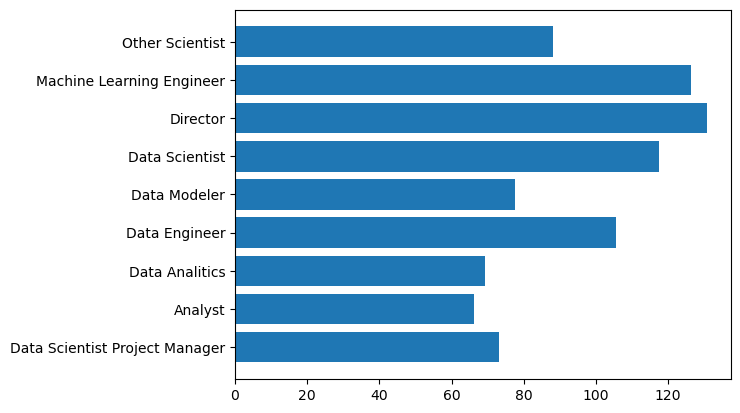

In [150]:
# create a horizotal bar chart to visualize relationship
fig, ax = plt.subplots()
plt.barh(range(len(jt_grouped_means)), jt_grouped_means)
ax.set_yticks(range(len(job_titles)))
ax.set_yticklabels(job_titles)
plt.show()

Here we see that jobs titled 'Director', 'Machine Learning Engineer', and 'Data Scientist' have the highest salaries on average.

### Average Salary by Type of Ownership

In [151]:
# group by ownership and get mean avg salary
ownership_grouped = nomissing_DS.groupby('Type of ownership')
own_grouped_means = ownership_grouped['Avg Salary(K)'].mean()
# create a list of ownership types aligned with the internal order of the grouped means
ownership_types = ['College/University', 'Private Company',
                  'Public Company', 'Government', 'Hospital',
                  'Nonprofit', 'Other', 'School', 'Subsidiary']

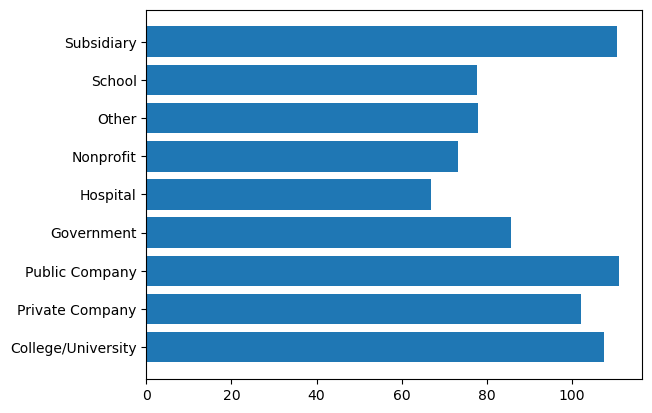

In [152]:
# create a horizotal bar chart to visualize relationship
fig, ax = plt.subplots()
plt.barh(range(len(own_grouped_means)), own_grouped_means)
ax.set_yticks(range(len(ownership_types)))
ax.set_yticklabels(ownership_types)
plt.show()

Here we see data science jobs in subsidiaries of larger corporations, public companies, and at colleges or universities have the highest average salary.